In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle

import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    

import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Loading in SLP and wind fields

In [2]:
%%time
base = '/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/'
vars = ['psl', 'uas', 'vas']
sel_lat = [0, 80] # [0, 55] = select 90°S - 60°S, [0, 80] = select 90°S - 45°S

# first, get a land-sea mask
tos = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/' + 'land_sea_mask_320x640_ucells.nc').tos[0,sel_lat[0]:sel_lat[1],:].load()
tos = tos.fillna(0) # replace all nan with zeroes
landsea_mask = tos.where(tos>=0,1).where(tos<=0,1).where(tos != 0) # replace all non-zero data with ones and all ones with NaN

for f in range(3):
    # load in SLP and convert to hPa
    ds = xr.open_dataset(base + 'JRA55-do-1-3_' + vars[f] + '_monthly_mean_1958-2018.nc')[vars[f]].groupby("time.season").mean('time')[:,sel_lat[0]:sel_lat[1],:].load()
    
    # save data sets for plotting
    if f == 0: psl = (ds / 100) # convert sea level pressure to hPa unit
    if f == 1: uas = ds
    if f == 2: vas = ds
# Wall time: 3.82 s

CPU times: user 8.29 s, sys: 6.11 s, total: 14.4 s
Wall time: 37 s


### Load in data to plot the 1000 m isobath in the figures

In [3]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht[0:500,:].load() # only load in 81°S - 60°S

In [4]:
bathymetry = field
bathymetry = bathymetry.where(bathymetry < 1000, np.nan)

CPU times: user 16.5 s, sys: 2.82 s, total: 19.4 s
Wall time: 17.3 s


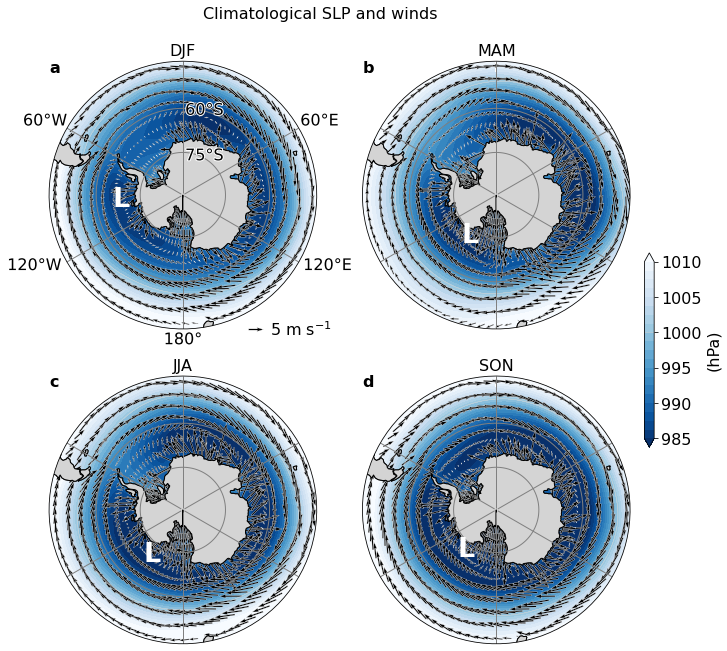

In [5]:
%%time
import matplotlib.path as mpath 
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
# ------------------------------------------------------------------- #
skala = 90
stitel = ['DJF', 'MAM', 'JJA', 'SON']
var = ['psl', 'uas', 'vas']
ticks = np.linspace(985, 1010, 21)

# ---------------------------- subplot 1 ---------------------------- #

# initialise figure
fig = plt.figure(figsize=(9, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2) 

for f in range(4): # loop through the four seasons

    if f == 0: panel = gs[0,0]  
    if f == 1: panel = gs[0,1]  
    if f == 2: panel = gs[1,0]
    if f == 3: panel = gs[1,1]


    ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))
    ax1.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())

    # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
    p1  = psl[f,:,:].plot.contourf(ax=ax1, cmap= 'Blues_r', levels = ticks, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = psl[f,:,:].plot.contour(levels = [1000], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree()) #d4d4d4 = lightgrey = [.83, .83, .83] in HEX
    # p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
    # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    

    # Add the wind stress arrows, only plotting every 30th data point.
    mask = np.logical_or(uas[0] != 0,uas[1] !=0) ## <-- corrected: one operation less
    X = uas.lon; Y = uas.lat; U = uas[f,:,:]; V = vas[f,:,:]; abstand = 7 # specifics for the wind speed arrows

    # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
    Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), scale=skala, 
                   scale_units='height', minshaft=2, transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w'))        
    # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    

    if f == 0: # add reference key,  x0,   y0 of quiver key
        qk = plt.quiverkey(Q,        .8,    0, 5, r'5 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) # add quiver if first subpanel

        # add labels
        xlab =    [  1.01,    1.04,     .5,   -.055,  -.015,    .58,    .58] # x-position of labels
        ylab =    [   .76,     .22,  -.057,     .22,    .76,    .63,    .80] # y-position of labels
        txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S', '60°S'] # label text

        # loop through the 7 labels and surround with white space for higher visibility
        for l in range(len(txt_lab)):
            ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                    fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 


    ax1.text(0, .96, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    fancy_plot(ax1); plt.title(stitel[f], fontsize=16)

    peak_anom_lon = psl[f,:,320:535].where(psl[f,:,320:535] == psl[f,:,320:535].min(), drop=True).lon # find minimum in region 60°W-180°W (300°E-180°E)
    peak_anom_lat = psl[f,:,320:535].where(psl[f,:,320:535] == psl[f,:,320:535].min(), drop=True).lat 

    # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
    txt = plt.text(peak_anom_lon[0], peak_anom_lat[0], 'L', c='w', fontsize=27, 
                   fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker

            
cax = fig.add_axes([1, .32, .015, .3]) # position: [x0, y0, width, height]
cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical'); 
cb.set_label(label='(hPa)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p11) # add contours to colour bar

plt.suptitle('Climatological SLP and winds', fontsize=16, y=1)
# --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
plt.savefig(save + 'Climatological_SLP_and_winds_for_SI_figure', #
            dpi=300, facecolor='w',                                                                    #
            edgecolor='w', orientation='landscape',                                                    #
            format=None, transparent=False, bbox_inches='tight',                                       #
            pad_inches=0.1, metadata=None)                                                             #
# --- end of script ---------------------------------------------------------------------------------- # 
# Wall time: 1min 21s

### Zoom into the West Antarctic region with the cake plot

In [6]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  

# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 30), # longitude grid lines
                  ylocs= np.linspace(0, -90, num=10)) # latitude grid lines
    ax.coastlines(); # add coast lines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    xlab =    [   .93,     .06,   -.01,    .15,     .3,     .36,    .68]#,     .41] # x-position of labels
    ylab =    [    .7,      .7,    .29,    .11,   -.07,       1,      1]#,     .05] # y-position of labels
    txt_lab = ['60°W', '150°W', '60°S', '70°S', '80°S', '120°W', '90°W']#, '150°W'] # label text
    # loop through the 7 label and surround with white space for higher visibility
    if f == 0:
        for l in range(len(xlab)):
            ax.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                    fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

# load in the unmasked coordinates
var = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'] # get the unmasked coordinates for plotting later on
for f in range(4):
    ds = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc')[var[f]] # get the dataset structure
    ds.values = xr.open_mfdataset('/g/data/ik11/grids/ocean_grid_01.nc')[var[f]].values # feed in the unmasked data into the dataset structure
    if f == 0: geolon_t = ds
    if f == 1: geolat_t = ds
    if f == 2: geolon_c = ds
    if f == 3: geolat_c = ds # I need the xarray.DataArray 'geolon_t' (yt_ocean: 2700xt_ocean: 3600) structure for later on calculating the make_boundary_path() function

CPU times: user 2.16 s, sys: 999 ms, total: 3.16 s
Wall time: 13.9 s


CPU times: user 59.9 s, sys: 7.36 s, total: 1min 7s
Wall time: 58.2 s


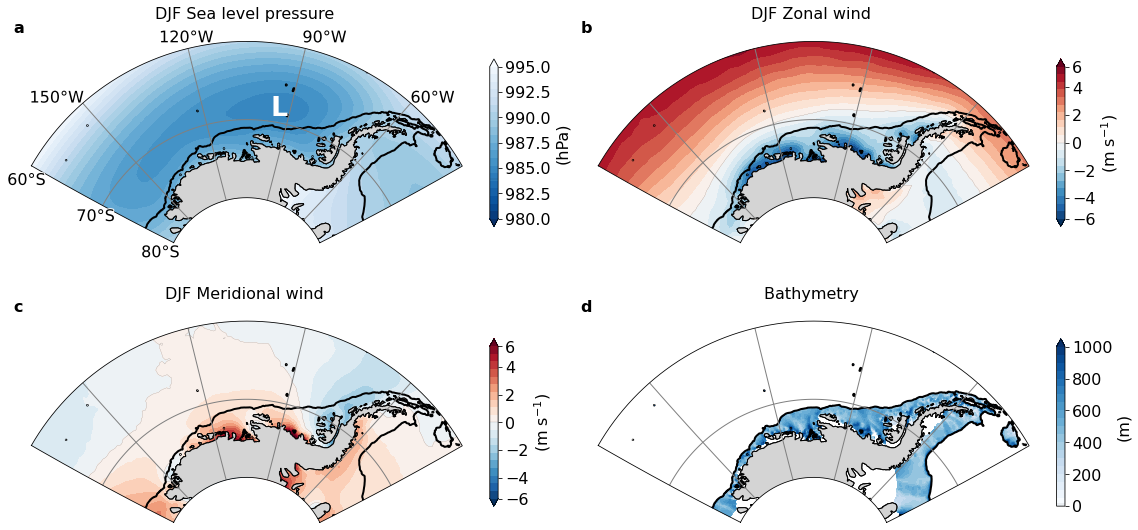

In [10]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(16, 10),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2) 

midlon = -105
maxlon = midlon + 65
minlon = midlon - 65
minlat = -80
maxlat = -60
midlat = (minlat + maxlat)/2
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00

for f in range(4): # loop through each subplot
    if f == 0:  panel = gs[0,0]; titel = 'DJF Sea level pressure \n'; map = psl[0,:,:]; farben = 'Blues_r'; ticks = np.linspace(980, 995, 21);      unit = '(hPa)'; richtung = 'both'
    if f == 1:  panel = gs[0,1]; titel = 'DJF Zonal wind \n';         map = uas[0,:,:]; farben = 'RdBu_r';  ticks = np.linspace( -5.5,  5.5, 21);   unit = '(m s$^{-1}$)'; richtung = 'both'
    if f == 2:  panel = gs[1,0]; titel = 'DJF Meridional wind \n';    map = vas[0,:,:]; farben = 'RdBu_r';  ticks = np.linspace( -5.5,   5.5, 21);  unit = '(m s$^{-1}$)'; richtung = 'both'
    if f == 3:  panel = gs[1,1]; titel = 'Bathymetry \n';             map = bathymetry; farben = 'Blues';  ticks = np.linspace(0, 1000, 21); unit = '(m)'; richtung = 'max'

    # panels with spatial maps -------------------------------------------------------------------------------------------------------------------- #
    ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
    ax1.coastlines(resolution='50m')

    lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
    lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

    ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

    boundary_path = make_boundary_path(lons, lats)
    ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

    # ----------------------------------------------------------------------------------------------------------------------------------------- #
    p1   = map.plot.contourf(add_colorbar=False, levels=ticks, cmap=farben, transform=ccrs.PlateCarree(), extend=richtung, vmin=ticks[0], vmax=ticks[1]); 

    p11  = map.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree(), extend='both')
    p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
    # ----------------------------------------------------------------------------------------------------------------------------------------- #
    

    cb = plt.colorbar(p1, shrink=.4, orientation='vertical'); 
    cb.set_label(label=unit, size=16)
    cb.ax.tick_params(labelsize=16);
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator;cb.update_ticks(); 
    cb.add_lines(p11) # add contours to colour bar


    if f == 0: # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
        peak_anom_lon = psl[0,:,320:535].where(psl[0,:,320:535] == psl[0,:,320:535].min(), drop=True).lon # find minimum in region 60°W-180°W (300°E-180°E)
        peak_anom_lat = psl[0,:,320:535].where(psl[0,:,320:535] == psl[0,:,320:535].min(), drop=True).lat 
        txt = plt.text(peak_anom_lon[0], peak_anom_lat[0], 'L', c='w', fontsize=27, 
                       fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
    
#     # Add the wind stress arrows, only plotting every 30th data point.
#     mask = np.logical_or(uas[0] != 0,uas[1] !=0) ## <-- corrected: one operation less
#     X = uas.lon; Y = uas.lat; U = uas[f,:,:]; V = vas[f,:,:]; abstand = 3 # specifics for the wind speed arrows
#     # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
#     Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), scale=skala, 
#                    scale_units='height', minshaft=2, transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w'))        
#     if f == 0: # add reference key,  x0,   y0 of quiver key
#         qk = plt.quiverkey(Q,        .8,    0, 5, r'5 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) # add quiver if first subpanel
#     # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    

    fancy_plot(ax1); # plt.suptitle('Shelf temperatures and surface wind stress', fontsize=16)
    plt.title(titel, fontsize=16)
    ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

    # if f == 0:
    #     cax = fig.add_axes([1, .2, .015, .3]) # position: [x0, y0, width, height]
    #     cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical'); 
    #     cb.set_label(label='(hPa)', size=16)
    #     cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
    #     cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p11) # add contours to colour bar
    # if f == 1:
    #     cax = fig.add_axes([1.1, .2, .015, .3]) # position: [x0, y0, width, height]
    #     cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical'); 
    #     cb.set_label(label='(m s$^{-1}$)', size=16)
    #     cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
    #     cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p11) # add contours to colour bar
    # del p1
# plt.suptitle('December-January-February climatological conditions', fontsize=16)
# --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
plt.savefig(save + 'Climatological_SLP_and_winds_for_SI_figure_cake', #
            dpi=300, facecolor='w',                                                                    #
            edgecolor='w', orientation='landscape',                                                    #
            format=None, transparent=False, bbox_inches='tight',                                       #
            pad_inches=0.1, metadata=None)                                                             #
# --- end of script ---------------------------------------------------------------------------------- # 
# Wall time: 1min 21s

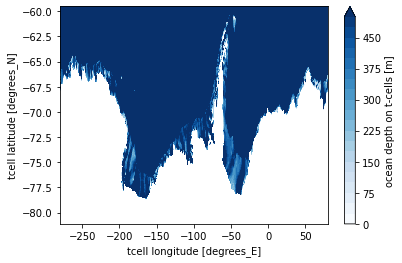

In [8]:
field.plot(levels=np.linspace(0,500,21), cmap='Blues')

In [9]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #